## Import required libraries

In [89]:
from collections import Counter
from typing import Dict, List, Tuple
import ast
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

## Load and prepare all public australian airbnb data from Q4 2022
#### Read and merge data

In [90]:
data_path = "./data/listings/"
data = pd.DataFrame()
for file_name in os.listdir(data_path):
    data = pd.concat([data, pd.read_csv(f"{data_path}{file_name}", sep=",")], ignore_index=True)

#### Drop duplicated identifier

In [91]:
data.sort_values(by="last_scraped", ascending=False, inplace=True)
data.drop_duplicates(subset=["id"], keep="first", ignore_index=True, inplace=True)

#### Convert string values into numeric amounts

In [92]:
data["price_amount"] = [float(price_str[1:].replace(",", "")) for price_str in data["price"]]

data["host_response_rate"] = [
    int(response_rate.replace("%", "")) if pd.notnull(response_rate) else np.NaN
    for response_rate in data["host_response_rate"]
]

#### Normalize amenity values

In [93]:
def normalize_amenity(amenity: str) -> str:
    """
    Normalize an amenity value for a better standardization.
    
    :param amenity: amenity string value that will be normalized
    :return: normalized amenity value
    """
    amenity = amenity.lower()
    amenity = amenity.replace("-", " ")
    amenity = re.sub(r"[^\w\s]", " ", amenity)
    amenity = re.sub(r"[\s]{2,}", " ", amenity)
    amenity = amenity.strip()
    return amenity

data["amenities"] = [[normalize_amenity(amenity) for amenity in ast.literal_eval(amenities)] for amenities in data["amenities"]]

## 1 -  What are the most common amenities for australian airbnb accommodations?
#### Count total occurrences of each amenity

In [94]:
def count_occurrences_of_amenities(amenities: pd.Series) -> Counter:
    """
    Count all occurences of each amenity.
    
    :param amenities: amenities data from all acommodations
    :return: total count per amenity
    """
    total_amenity_values = itertools.chain(*amenities)
    return Counter(total_amenity_values)

total_count_per_amenity = count_occurrences_of_amenities(data["amenities"])

#### Select the Top 20 amenties and calculate their relative share on all accommodations

In [95]:
top20_amenities = dict(sorted(total_count_per_amenity.items(), key=lambda x:x[1], reverse=True)[:20])
top20_values_in_percent = [round(value / len(data) * 100) for value in top20_amenities.values()]

#### Plot Top 20 amenities as horizontal barchart

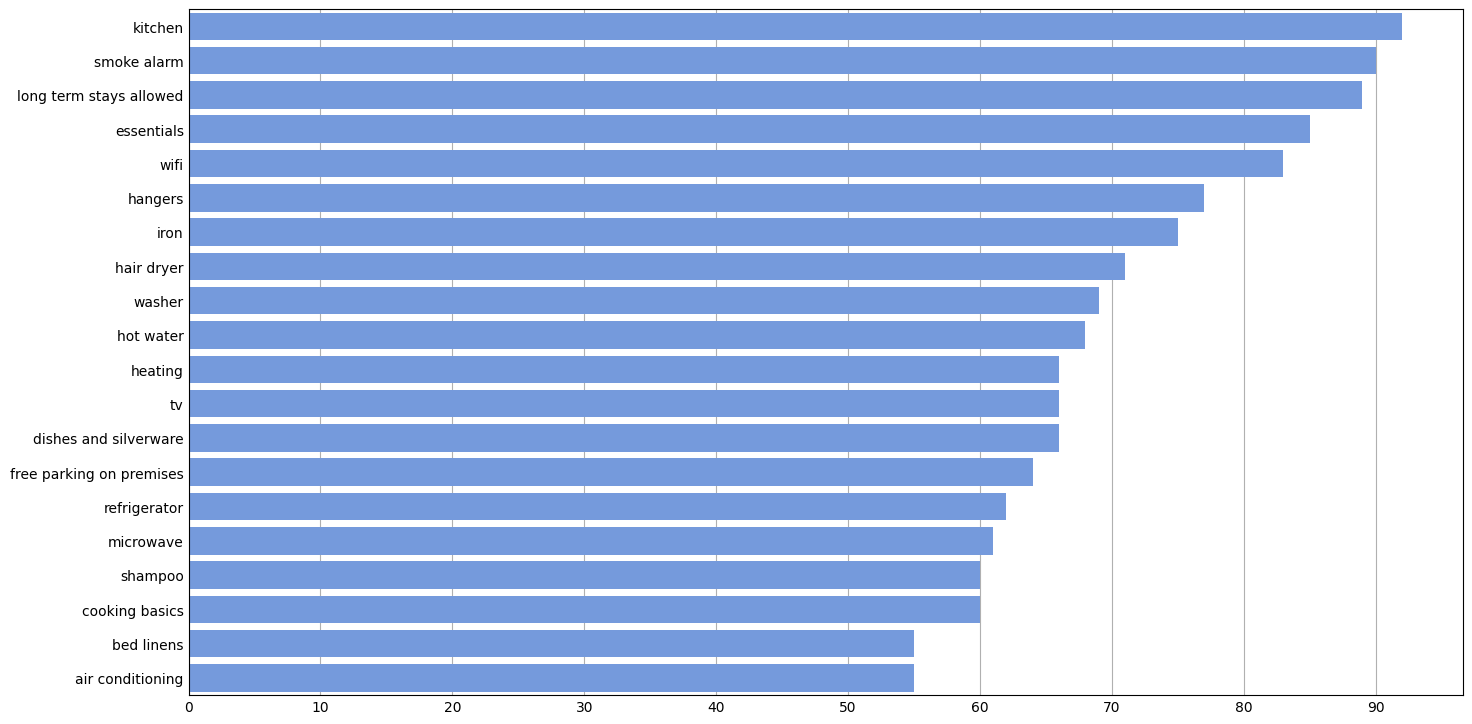

In [96]:
plt.figure(figsize=(13, 7))
plt.xticks(range(0,100,10))
sns.barplot(x=top20_values_in_percent, y=list(top20_amenities.keys()), color = "cornflowerblue");

**Answer:** There are five amenities that are present in 4 out of 5 accomodations: kitchen, smoke alarm, long term stays allowed, essentials and wifi. Over 90% of the australian accommodations have a kitchen, which is the most common amenity.

## 2 - Is there a coherence between the number of amenities and prices?
#### Count amenties per accommodation

In [97]:
data["amenities_count"] = [len(amenities) for amenities in data["amenities"]]

#### Remove price outliers

In [98]:
data = data[(data["price_amount"] > 10) & (data["price_amount"] < 5000)]

#### Build a scatterplot between the number of amenities and price 

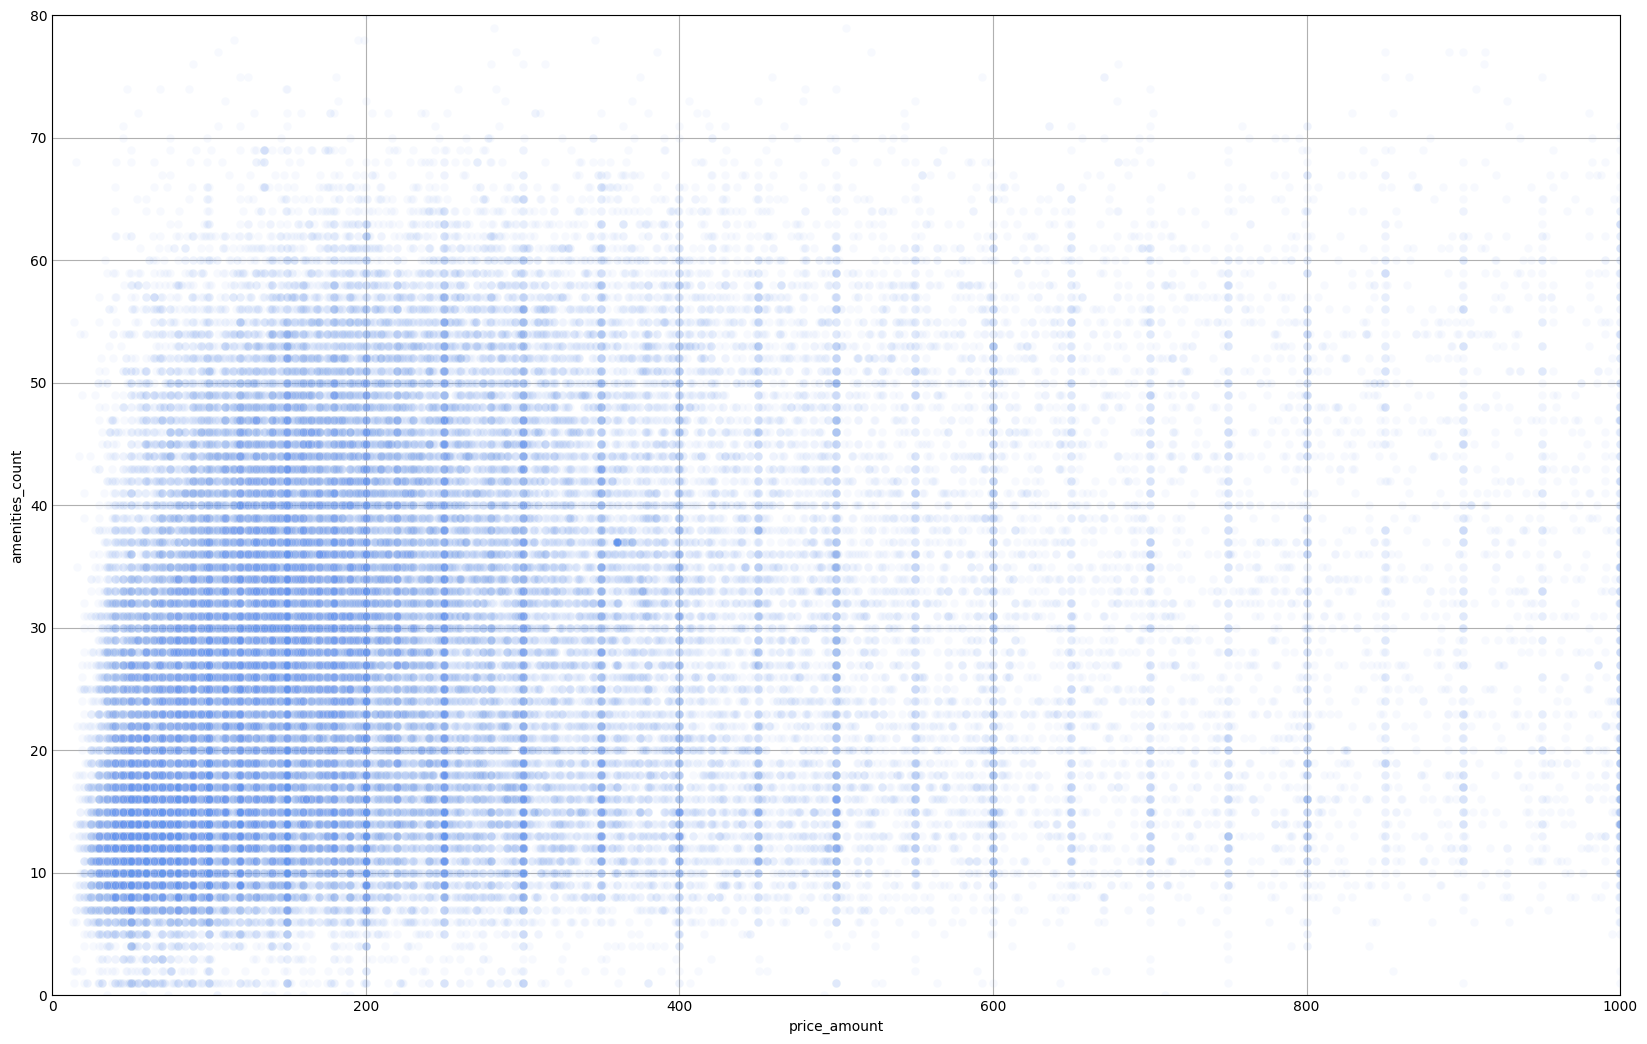

In [99]:
plt.figure(figsize=(16, 10))
plt.xlim(0,1000)
plt.ylim(0,80)
sns.scatterplot(y=data["amenities_count"], x=data["price_amount"], color = "cornflowerblue", alpha=0.05);

#### Calculate the correlation

In [100]:
print(f"correlation: {round(data['amenities_count'].corr(data['price_amount']), 3)}")

correlation: 0.141


**Answer:** There is a very weak correlation between the price and the number of amenities. The scatter plot with nearly equally distributed dots over the entire price axes also emphasizes that there is no coherence.

## 3 - Is there a coherence between the number of amenities and ratings?
#### Consider only ratings with at least five reviews (otherwise not meaningful)

In [101]:
data["rating_with_min_5_reviews"] = [
    rating if review_count >= 5 else np.NaN
    for rating, review_count in zip(data["review_scores_rating"], data["number_of_reviews"])
]
data = data[data["rating_with_min_5_reviews"].notnull() & data["rating_with_min_5_reviews"] > 0].reset_index(drop=True)

#### Build a scatterplot between the number of amenities and ratings

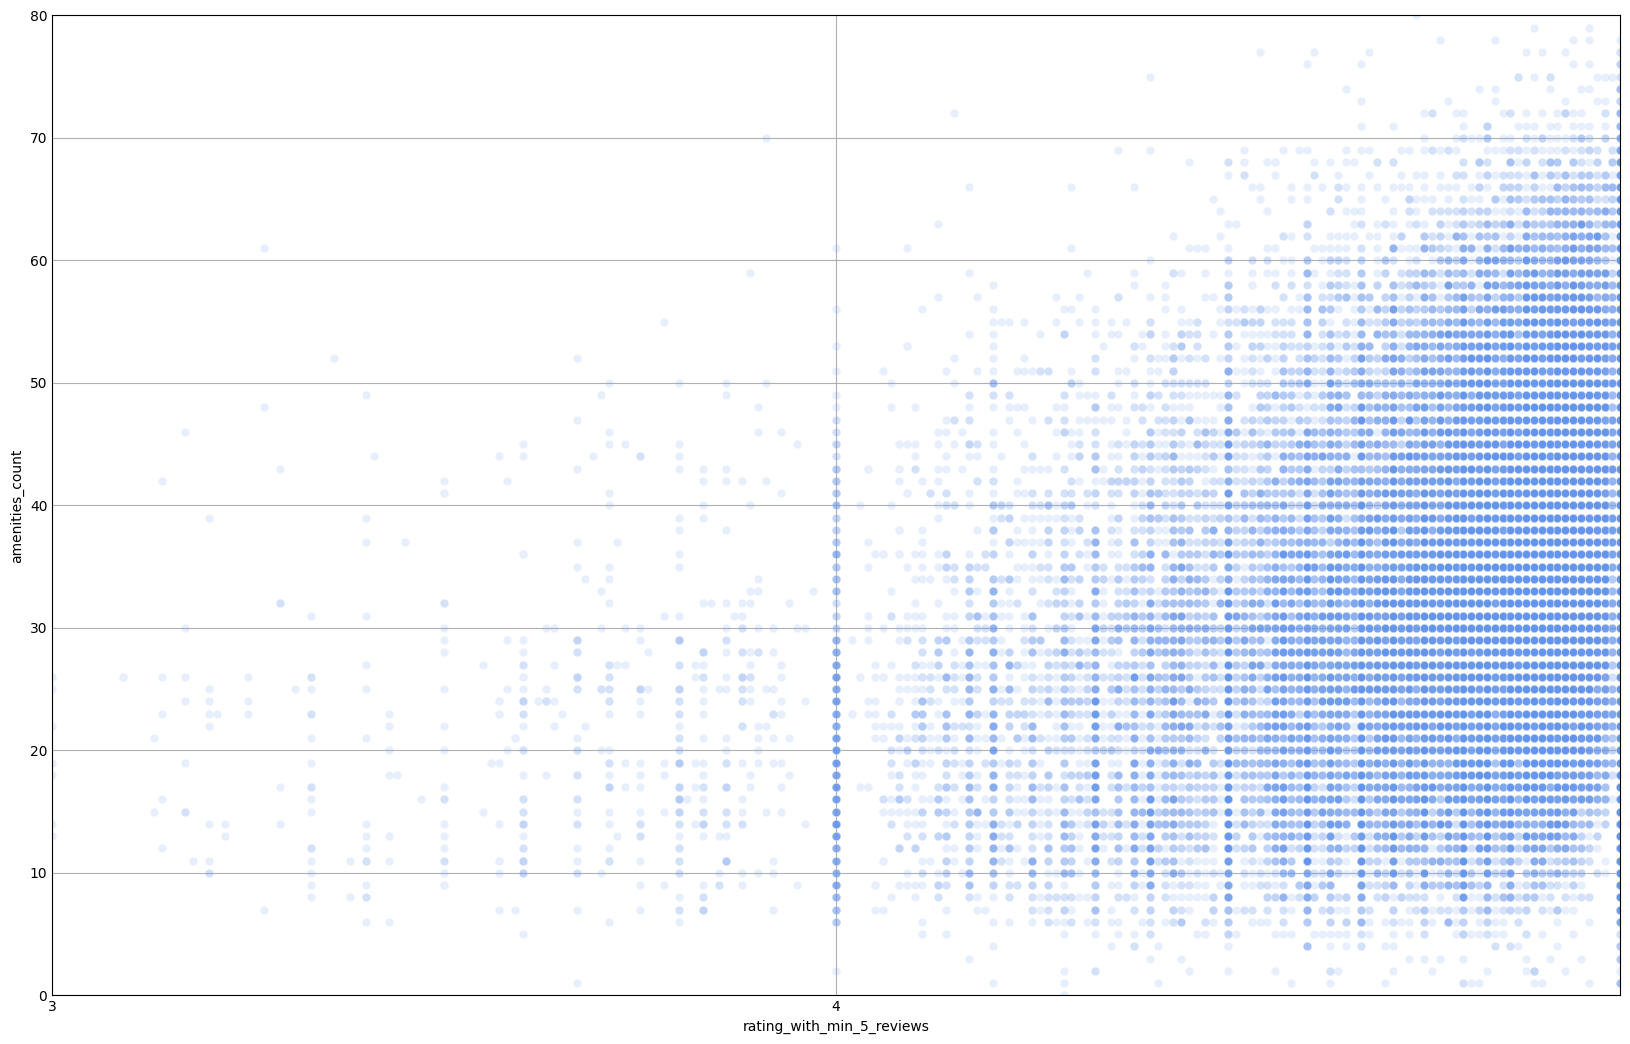

In [102]:
plt.figure(figsize=(16, 10))
plt.xticks(range(3,5,1))
plt.xlim(3,5)
plt.ylim(0,80)
sns.scatterplot(y=data["amenities_count"], x=data["rating_with_min_5_reviews"], color = "cornflowerblue", alpha=0.15);

*Note: Most of the ratings are between 3 and 5 which is why the axis is scaled to that range.*

#### Calculate the correlation

In [106]:
print(f"correlation: {round(data['amenities_count'].corr(data['rating_with_min_5_reviews']), 3)}")

correlation: 0.267


**Answer:** There is a low to moderate correlation between the rating values and the number of amenities. The scatterplot also shows, that the ratings tends to be higher, the more amenties an accommodation have.

## 4 - Is it possible to predict the rating of an australian airbnb accommodation?
#### Preselect relevant data for the rating model

In [107]:
numeric_rating_prediction_columns = [
    "host_response_rate",
    "accommodates",
    "bedrooms", 
    "beds",
    "price_amount",
    "amenities_count"
]

categorical_rating_prediction_columns = [
    "host_response_time",
    "host_is_superhost",
    "neighbourhood_cleansed",
    "property_type",
    "room_type",
    "bathrooms_text"
]

response_variable = "rating_with_min_5_reviews"

data = data[[response_variable] + numeric_rating_prediction_columns + categorical_rating_prediction_columns + ["amenities"]]

*Note: accommodations without a rating are already removed from the data in previous steps*

#### Impute missing numeric data

In [108]:
def impute_missing_numeric_data(data: pd.DataFrame, numeric_cols: List[str]) -> pd.DataFrame:
    """
    Fill null values of numeric attributes with the mean of the entire column.
    
    :param data: data for the rating model
    :param numeric_cols: numeric columns whose missing values will be replaced
    :return: data for the rating model without missing numeric values
    """    
    for numeric_col in numeric_cols:
        data[numeric_col] = data[numeric_col].fillna(data[numeric_col].mean())
        
    return data


data = impute_missing_numeric_data(data, numeric_rating_prediction_columns)

/tmp/ipykernel_67/1305192379.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[numeric_col] = data[numeric_col].fillna(data[numeric_col].mean())


#### Convert amenities data into dummies

In [109]:
def remove_unusual_amenities(total_count_per_amenity: Counter, min_amenity_count: int) -> Dict[str, int]:
    """
    Remove unusual amenities based on their total number of occurrences.
    
    :param total_count_per_amenity: all amenities with their total number of occurrences
    :param min_amenity_count: minimum occurences to remain in the data
    :return: total count per amenity for all usual amenities
    """
    origin_total_amenity_keys = len(total_count_per_amenity.keys())
    origin_total_amenity_values = sum(total_count_per_amenity.values())
    
    total_count_per_amenity = {amenity: amenity_count for (amenity, amenity_count) in total_count_per_amenity.items() if amenity_count >= min_amenity_count}

    print(f"Removed {round(abs(len(total_count_per_amenity.keys()) / origin_total_amenity_keys - 1) * 100, 1)}% amenity keys "
          f"but only {round(abs(sum(total_count_per_amenity.values()) / origin_total_amenity_values - 1) * 100, 1)}% of the set amenity values in total.")
    
    return total_count_per_amenity


def convert_amenities_data_into_dummies(data: pd.DataFrame, min_amenity_count: int) -> pd.DataFrame:
    """
    Convert the list of amenities for each accommodation into dummy variables.
    
    :param data: data for the rating model
    :param min_amenity_count: minimum occurences to remain in the data
    :return: data for the rating model with dummies for the amenity data
    """
    total_count_per_amenity = Counter(itertools.chain(*data["amenities"]))

    total_count_per_amenity = remove_unusual_amenities(total_count_per_amenity, min_amenity_count)
    
    amenity_dummies = pd.concat(
        [pd.Series(name=f"amenity_{amenity.replace(' ', '_')}",
                   data=[1 if amenity in accomodation_amenities else 0 for accomodation_amenities in data["amenities"]]) 
         for amenity in total_count_per_amenity.keys()], axis=1
    )
    
    data = pd.concat([data.drop(columns=["amenities"]), amenity_dummies], axis=1)

    return data


data = convert_amenities_data_into_dummies(data, min_amenity_count=200)

Removed 97.2% amenity keys but only 1.8% of the set amenity values in total.


#### Convert other categorical data into dummies

In [ ]:
def convert_other_categorical_data_into_dummies(data: pd.DataFrame, categorical_cols: List[str]) -> pd.DataFrame:
    """
    Convert categorical attributes into dummy variables.
    
    :param data: data for the rating model
    :param categorical_cols: categorical columns that will be converted
    :return: data for the rating model with dummy variables for categorical data columns
    """
    data = pd.get_dummies(data, prefix=categorical_cols, columns=categorical_cols, dummy_na=False, drop_first=False)
    return data
    
    
data = convert_other_categorical_data_into_dummies(data, categorical_rating_prediction_columns)

#### Cutoff categorical data with almost only zero values to avoid overfitting

In [ ]:
def cutoff_categorical_data_with_almost_only_zero_values(data: pd.DataFrame, categorical_cols: List[str], cutoff: int) -> pd.DataFrame:
    """
    Remove dummy variables that have almost only zero values to avoid overfitting.
    
    :param data: data for the rating model
    :param categorical_cols: categorical columns that will be converted
    :param cutoff: minimum threshold of 1-values to remain in the data
    :return: data for the rating model without dummy variables that are almost only zero
    """
    cutoff_cols = []
        
    for cat_col in categorical_cols:
        cat_col_dummies = data.columns[data.columns.str.startswith(f"{cat_col}_")]
        for cat_col_dummy in cat_col_dummies:
            if data[cat_col_dummy].sum() <= cutoff:
                cutoff_cols.append(cat_col_dummy)
                
    data = data.drop(columns=cutoff_cols).reset_index(drop=True)
    
    return data


data = cutoff_categorical_data_with_almost_only_zero_values(data, categorical_rating_prediction_columns + ["amenity"], cutoff=50)

#### Split data into test/train and build linear regression model

In [ ]:
def build_linear_model(X: pd.DataFrame, y: pd.Series, test_size=.3, rand_state=42) -> Tuple:
    """
    INPUT:
    X
    y
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    OUTPUT:
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    """
       
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)
    
    model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())
    model.fit(X_train, y_train)
        
    return model, X_train, X_test, y_train, y_test


model, X_train, X_test, y_train, y_test = build_linear_model(data.drop(columns=[response_variable]), data[response_variable])

#### Predict rating for test/train data and calculate r2 score

In [ ]:
def predict_rating(model, X, y) -> Tuple:
    """
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    """

    y_predicted = model.predict(X)
    score = r2_score(y, y_predicted)
    
    return y_predicted, score


y_train_predicted, y_train_score = predict_rating(model, X_train, y_train)
y_test_predicted, y_test_score = predict_rating(model, X_test, y_test)

In [ ]:
y_train_score

In [ ]:
y_test_score

#### Show the most influential coefficients of the built model

In [ ]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = coefficients
    coefs_df['abs_coefs'] = np.abs(coefficients)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

coef_df = coef_weights(model.named_steps["linearregression"].coef_, X_test)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

coef_df.head(10)